In [1]:
# Standard Imports
import numpy as np
from time import time
import pandas as pd
from matplotlib import pyplot as plt

# SHAPER
from src.Observables import Observable
from src.CommonObservables import NSubjettiness
from src.Shaper import Shaper
from src.Manifolds import Coordinates2D, Simplex, PositiveReals

# Utils
from utils.data_utils import load_cmsopendata
from utils.plot_utils import plot_event

# Jets
from pyjet import cluster


/home/rikab/miniconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Data

Max # of particles: 91
Max # of particles: 111
test


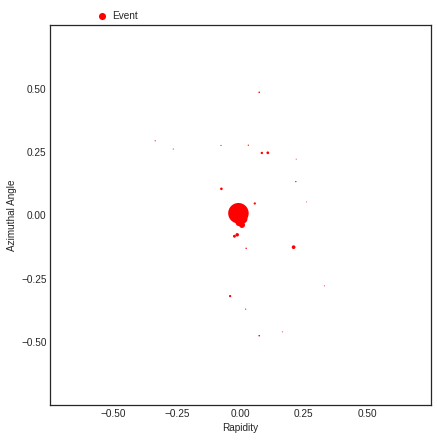

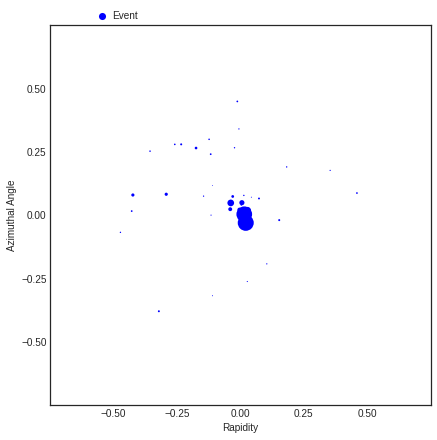

<AxesSubplot:xlabel='Rapidity', ylabel='Azimuthal Angle'>

In [2]:
# Parameters
R = 0.5
beta = 1.0
N = 100
batch_size = min(500,N)
pt_lower = 475
pt_upper = 525
eta = 1.9
quality = 2
pad = 125
plot_dir = "results"

cms, cms_weights = load_cmsopendata("data", "cms", pt_lower, pt_upper, eta, quality, pad, n = N)
sim, sim_weights, sim_factors = load_cmsopendata("data", "sim", pt_lower, pt_upper, eta, quality, pad, n = N)


# fake_top, fake_top_z = np.array(( (-R/4,0.0), (0.0,0.0), (R/4,0.0),)), np.array((1/3, 1/3, 1/3))
# cms = (fake_top, fake_top_z)
# fake_quark, fake_quark_z = np.array(((0.0,0.0),)), np.array((1.0, ))
# sim = (fake_quark, fake_quark_z)


# Example plots
example_cms = cms[0]
plot_event(example_cms[0], example_cms[1], R, color = "red")

example_sim = sim[0]
plot_event(example_sim[0], example_sim[1], R, color = "blue")


def plot_hist(cms_arr, sim_arr, color, label, variable_name, lims,):

    bins = 15
    n = len(cms_arr)
    counts,bin_edges = np.histogram(cms_arr,bins = bins, range = lims, weights= cms_weights[:n] * N / n)
    sim_counts, sim_egdges = np.histogram(sim_arr,bins = bins, range = lims, weights= sim_weights[:n] * sim_factors[:n])
    step = bin_edges[1] - bin_edges[0]
    errs2 = np.histogram(cms_arr, bins=bins, weights=cms_weights[:n]*cms_weights[:n] * N**2 / n**2)[0]
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    
    axes[0].errorbar(bin_centres, counts, yerr = np.sqrt(errs2), xerr = step / 2, fmt='o', color = color, label = r"CMS " + label)
    axes[0].hist(sim_arr, bins = bins, weights = sim_weights[:n] * sim_factors[:n] * N / n, range = lims, color = color, alpha = 0.25, lw = 3, histtype= "step", label = r"SIM " + label)
    
    reg = 1e-6
    axes[1].errorbar(bin_centres, counts / (sim_counts + reg), xerr = step / 2, yerr = np.sqrt(errs2) / (sim_counts + reg), color = color, fmt = 'o')
    
    
    xlabel = variable_name
    ylabel = 'Differential Cross Section [nb]'

    for ax in axes:
            ax.minorticks_on()
            ax.tick_params(top=True, right=True, bottom=True, left=True, direction='in', which='both')

    axes[0].tick_params(labelbottom=False)
    axes[1].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)
    axes[1].set_ylabel("Data / Sim")

    axes[0].set_ylim([0.0, 1.25 * np.max(counts)])
    axes[1].set_ylim([0.5, 1.5])
    axes[1].axhline(1.0, color = "black", ls = "--")

    axes[0].set_title('%s Distributions - CMS Open Data' % variable_name, loc = "right")
    axes[0].legend(title = r"$N = %i$ Events" % n)


    return counts, bin_edges


BATCH: 0
Observable: 1 Point-Ringiness Epoch 0 Mean Loss = 0.038922287188470364 Elapsed time = 10.069s Percentage done = 0.000 
Observable: 1 Point-Ringiness Epoch 1 Mean Loss = 0.03683824608102441 Elapsed time = 10.416s Percentage done = 0.000 
Observable: 1 Point-Ringiness Epoch 2 Mean Loss = 0.035037252847105266 Elapsed time = 10.778s Percentage done = 0.000 
Observable: 1 Point-Ringiness Epoch 3 Mean Loss = 0.03475118218921125 Elapsed time = 11.124s Percentage done = 0.000 
Observable: 1 Point-Ringiness Epoch 4 Mean Loss = 0.03505482121370733 Elapsed time = 11.490s Percentage done = 0.000 
Observable: 1 Point-Ringiness Epoch 5 Mean Loss = 0.03456211926415562 Elapsed time = 11.810s Percentage done = 0.000 
Observable: 1 Point-Ringiness Epoch 6 Mean Loss = 0.034596890434622767 Elapsed time = 12.120s Percentage done = 0.000 
Observable: 1 Point-Ringiness Epoch 7 Mean Loss = 0.03487544042058289 Elapsed time = 12.449s Percentage done = 0.000 
Observable: 1 Point-Ringiness Epoch 8 Mean L

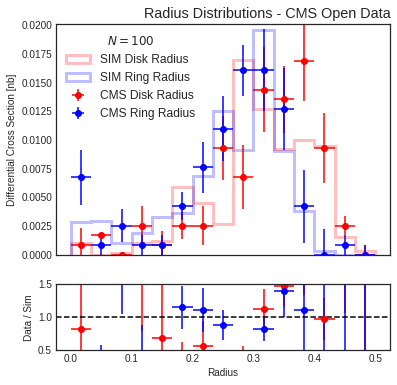

In [3]:
import torch 
import torch.nn as nn

from matplotlib.patches import Circle as pltCircle
from matplotlib.collections import PathCollection



# Basic Observables
_1subjettiness = NSubjettiness(1, beta = 1, R = R)
_2subjettiness = NSubjettiness(2, beta = 1, R = R)
_3subjettiness = NSubjettiness(3, beta = 1, R = R)


# Advanced Observables: Define a sampler and an (optional) plotter

def point_ring_sampler(N, param_dict):
    center = param_dict["Points"].params
    radius = param_dict["Radius"].params
    weights = param_dict["Structure Weights"].params

    phi = 2 * np.pi * torch.rand(N)
    points = torch.stack([torch.cos(phi), torch.sin(phi)], axis = 1) * radius + center

    # Concatenate and reweight
    e = torch.cat([center, points], dim = 0)
    z = torch.cat([weights[0] * torch.ones((1,)), weights[1] * torch.ones((N,)) / N], dim = 0)

    return (e, z)
    

def point_ring_plotter(ax, param_dict):

    center = param_dict["Points"].params.clone().detach().numpy()
    radius = param_dict["Radius"].params.clone().detach().numpy()
    weights = param_dict["Structure Weights"].params.clone().detach().numpy()

    # Ring
    draw_circle = pltCircle(center[0,:], radius[0], facecolor = None, edgecolor = "purple", fill = False,)
    ax.add_artist(draw_circle)

    # Center
    ax.scatter(center[:,0], center[:,1], color = "Purple", label = "Ring", marker = "x", s = 2 * weights[0] * 500/np.sum(weights), alpha = 0.5)
    
    # Points
    e, z = point_ring_sampler(50, param_dict)
    e = e.clone().detach().numpy()
    z = z.clone().detach().numpy()
    ax.scatter(e[:,0], e[:,1], color = "Purple", s = 2 * z * 500/np.sum(z), alpha = 0.25)

    # Text
    plt.text(0.05, 0.06 + 0.03*0, "Point: (%.3f, %.3f), Weight: %.3f, Radius: %.3f" % (center[0,0], center[0,1], weights[0], radius[0]), fontsize = 10, transform = plt.gca().transAxes)


def point_disk_sampler(N, param_dict):
    center = param_dict["Points"].params
    radius = param_dict["Radius"].params
    weights = param_dict["Structure Weights"].params

    phi = 2 * np.pi * torch.rand(N)
    r =  torch.sqrt(torch.rand(N))
    points = torch.stack([torch.cos(phi), torch.sin(phi)], axis = 1) * radius * r[:,None] + center


    # Concatenate and reweight
    e = torch.cat([center, points], dim = 0)
    z = torch.cat([weights[0] * torch.ones((1,)), weights[1] * torch.ones((N,)) / N], dim = 0)

    return (e, z)


def point_disk_plotter(ax, param_dict):

    center = param_dict["Points"].params.clone().detach().numpy()
    radius = param_dict["Radius"].params.clone().detach().numpy()
    weights = param_dict["Structure Weights"].params.clone().detach().numpy()

    # Circle
    draw_circle = pltCircle(center[0,:], radius[0], facecolor = "purple", edgecolor = "purple", alpha = 0.25)
    ax.add_artist(draw_circle)

    # Points
    e, z = point_disk_sampler(50, param_dict)
    e = e.clone().detach().numpy()
    z = z.clone().detach().numpy()
    ax.scatter(e[:,0], e[:,1], color = "Purple", s = 2 * z * 500/np.sum(z), alpha = 0.25)

    # Center
    ax.scatter(center[:,0], center[:,1], color = "Purple", label = "Disk", marker = "x", s = 2 * weights[0] * 500/np.sum(weights), alpha = 0.5)
    
    # Text
    plt.text(0.05, 0.06 + 0.03*0, "Point: (%.3f, %.3f), Weight: %.3f, Radius: %.3f" % (center[0,0], center[0,1], weights[0], radius[0]), fontsize = 10, transform = plt.gca().transAxes)


_point_ringiness = Observable({"Points" : Coordinates2D(1), "Structure Weights" : Simplex(2), "Radius" : PositiveReals(1, R/2)}, point_ring_sampler, beta = 1, R = R, initializer= "kt", plotter = point_ring_plotter)
_point_diskiness = Observable({"Points" : Coordinates2D(1), "Structure Weights" : Simplex(2), "Radius" : PositiveReals(1, R/2)}, point_disk_sampler, beta = 1, R = R, initializer= "kt", plotter = point_disk_plotter)

# List of observables we want to calculate
observables = {
    # "1 Subjettiness" : _1subjettiness,
    # "2 Subjettiness" : _2subjettiness,
    # "3 Subjettiness" : _3subjettiness,
    "1 Point-Ringiness" : _point_ringiness,
    "1 Point-Diskiness" : _point_diskiness,
}
shaper = Shaper(observables)


batches = int(N / batch_size)


cms_disk_emd = []
cms_ring_emd = []
sim_disk_emd = []
sim_ring_emd = []


cms_disk_rad = []
cms_ring_rad = []
sim_disk_rad = []
sim_ring_rad = []

plot_directory = None
gif_directory = None

for batch in range(batches):

    print("BATCH: %d" % batch)
    start = batch * batch_size
    end = (batch + 1) * batch_size
    cms_emds, cms_params = shaper.calculate(cms[start:end], epochs = 500, verbose=True, lr = 0.01, N = 100, scaling = 0.5, epsilon = 0.01, early_stopping= 25, plot_directory=plot_directory)
    sim_emds, sim_params = shaper.calculate(sim[start:end], epochs = 500, verbose=True, lr = 0.01, N = 100, scaling = 0.5, epsilon= 0.01, early_stopping= 25)

    for i in range(batch_size):
        cms_disk_rad.append(cms_params["1 Point-Diskiness"][i]["Radius"].params.detach().numpy()[0])
        cms_ring_rad.append(cms_params["1 Point-Ringiness"][i]["Radius"].params.detach().numpy()[0])

        sim_disk_rad.append(sim_params["1 Point-Diskiness"][i]["Radius"].params.detach().numpy()[0])
        sim_ring_rad.append(sim_params["1 Point-Ringiness"][i]["Radius"].params.detach().numpy()[0])


        cms_disk_emd.append(cms_emds["1 Point-Diskiness"][i])
        cms_ring_emd.append(cms_emds["1 Point-Ringiness"][i])

        sim_disk_emd.append(sim_emds["1 Point-Diskiness"][i])
        sim_ring_emd.append(sim_emds["1 Point-Ringiness"][i])


    n = len(cms_disk_rad)

    gridspec_kw = {'height_ratios': (3.5, 1) }

    fig, axes = plt.subplots(2,  gridspec_kw=gridspec_kw,figsize=(6,6))
    plt.rcParams['font.size'] = '12'


    counts,bin_edges = plot_hist(cms_disk_rad, sim_disk_rad, "red", "Disk Radius", 'Radius', [0,R])
    counts,bin_edges = plot_hist(cms_ring_rad, sim_ring_rad, "blue", "Ring Radius", 'Radius' [0,R])

    plt.show()


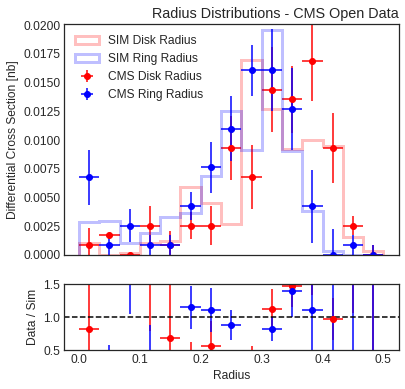

In [4]:


counts,bin_edges = plot_hist(cms_disk_rad, sim_disk_rad, "red", "Disk Radius", "Radius", [0,R])
counts,bin_edges = plot_hist(cms_ring_rad, sim_ring_rad, "blue", "Ring Radius", "Radius", [0,R])
plt.savefig("Radii.png")

counts,bin_edges = plot_hist(cms_disk_emd, sim_disk_rad, "red", "Disk EMD", "EMD", [0,.25])
counts,bin_edges = plot_hist(cms_ring_emd, sim_ring_rad, "blue", "Ring EMD", "EMD", [0,.25])
plt.savefig("Radii.png")


0.02580122304614632
0.029109728471375995


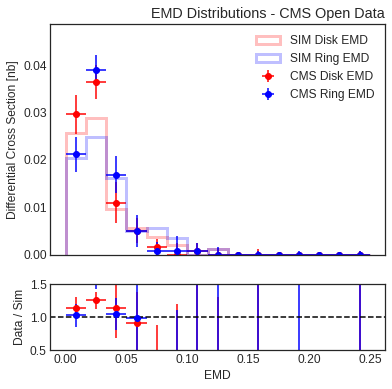

In [5]:
n = len(cms_disk_emd)

lims = [0, .25]

gridspec_kw = {'height_ratios': (3.5, 1) }

fig, axes = plt.subplots(2,  gridspec_kw=gridspec_kw,figsize=(6,6))
plt.rcParams['font.size'] = '12'

def plot_hist(cms_arr, sim_arr, color, label):

    bins = 15
    counts,bin_edges = np.histogram(cms_arr,bins = bins, range = lims, weights= cms_weights[:n])
    sim_counts, sim_egdges = np.histogram(sim_arr,bins = bins, range = lims, weights= sim_weights[:n] * sim_factors[:n])
    step = bin_edges[1] - bin_edges[0]
    errs2 = np.histogram(cms_arr, bins=bins, weights=cms_weights[:n]*cms_weights[:n])[0]
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    
    axes[0].errorbar(bin_centres, counts, yerr = np.sqrt(errs2), xerr = step / 2, fmt='o', color = color, label = r"CMS " + label)
    axes[0].hist(sim_arr, bins = bins, weights = sim_weights[:n] * sim_factors[:n], range = lims, color = color, alpha = 0.25, lw = 3, histtype= "step", label = r"SIM " + label)
    
    reg = 1e-6
    axes[1].errorbar(bin_centres, counts / (sim_counts + reg), xerr = step / 2, yerr = np.sqrt(errs2) / (sim_counts + reg), color = color, fmt = 'o')
    
    print(np.average(cms_arr, weights= cms_weights))
    
    return counts, bin_edges


counts,bin_edges = plot_hist(cms_disk_emd, sim_disk_emd, "red", "Disk EMD")
counts,bin_edges = plot_hist(cms_ring_emd, sim_ring_emd, "blue", "Ring EMD")


xlabel = r'EMD'
ylabel = 'Differential Cross Section [nb]'

for ax in axes:
        ax.minorticks_on()
        ax.tick_params(top=True, right=True, bottom=True, left=True, direction='in', which='both')

axes[0].tick_params(labelbottom=False)
axes[1].set_xlabel(xlabel)
axes[0].set_ylabel(ylabel)
axes[1].set_ylabel("Data / Sim")

axes[0].set_ylim([0.0, 1.25 * np.max(counts)])
axes[1].set_ylim([0.5, 1.5])
axes[1].axhline(1.0, color = "black", ls = "--")

axes[0].set_title('EMD Distributions - CMS Open Data', loc = "right")
axes[0].legend()

plt.savefig("EMD.png")